In [1]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [2]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [4]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [9]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


In [14]:
#s_xy = [[1.,i,i+1] for i in range(L-1)]
#s_z = [[0.47,i] for i in range(L)]

#ham_map = [
    
#    ["xx",s_xy],
#    ["yy",s_xy],
#    ["z",s_z],


#]

#XYZ = hamiltonian(ham_map,dynamic_list=[],basis=basis,**no_checks)


In [15]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [16]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [17]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [18]:
def R(i,theta):
    
    if i%11 == 0:
        return(ms_gate_global(theta))
    
    if i%11 == 1:
        return(ms_gate_global_1(theta))
    

    if i%11 == 2:
        return(rot_sigma_e(0,1,0,theta).toarray())


    if i%11 == 3:
        return(rot_sigma_e(0,2,0,theta).toarray())

    
    if i%11 == 4:
        return(rot_sigma_e(1,2,np.pi/2,theta).toarray())
    
    
    if i%11 == 5:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%11 == 6:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%11 == 7:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%11 == 8:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%11 == 9:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%11 == 10:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i):
    
    if i%11 == 0:
        return(-1j*matrix_part)
    

    if i%11 == 1:
        return(-1j*matrix_part_1)
    

    if i%11 == 2:
        return(-1j*sigma_e(0,1,0).toarray())

    
    if i%11 == 3:
        return(-1j*sigma_e(0,2,0).toarray())

    
    if i%11 == 4:
        return(-1j*sigma_e(1,2,np.pi/2).toarray())


     
    if i%11 == 5:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%11 == 6:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%11 == 7:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%11 == 8:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%11 == 9:
        return(-1j*sigma_r(0,2,0).toarray())

    
    if i%11 == 10:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [19]:
coeff = 11

In [20]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)
    A = []
    B = []
    for k in range(coeff*N):
        A.append(S(k)@R(k,theta[k]))
        B.append(R(k,theta[k]))
        
    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)
    AA = np.einsum("ijk,il->iljk",A,ID)
    BB = np.einsum("ijk,il->iljk",B,ID)
    DD = CC-BB+AA
    dd = []
    for i in range(coeff*N):
        dd.append(reduce(np.dot,DD[i]))
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)
    
    BBB = reduce(np.dot,B)

    DD_d = np.einsum("kij->kji",DD.conj())
    X = np.einsum("m,imn,jnl,l->ij",np.conj(psi_0),DD_d,DD,psi_0)
    Y = np.einsum("m,imn,nl,lk,k->i",np.conj(psi_0),DD_d,full_ham_matrix.toarray(),BBB,psi_0)
    XX = np.einsum("m,imn,nk,k->i",np.conj(psi_0),DD_d,BBB,psi_0)
    YY_1 = np.einsum("m,mn,ink,k->i",np.conj(psi_0),BBB.conj().T,DD,psi_0)
    YY_2 = np.einsum("m,mn,nk,kl,l",np.conj(psi_0),BBB.conj().T,full_ham_matrix.toarray(),BBB,psi_0 )
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    #v = 1e-6*np.exp(-0)*np.ones(coeff*N)
    #v = np.zeros(coeff*N)
    #X = X + np.diag(v)
    print(t)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.imag(Y+YY)

    return np.linalg.pinv(X_r,rcond = 1e-6)@Y_i

In [21]:
stepp = 10000

In [22]:
time_domain = np.linspace(0, 30, stepp)
Y = []

In [23]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [24]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
import datetime
print(datetime.datetime.now())
rk4(0,0.001*np.ones(coeff*N),30,stepp)
print(datetime.datetime.now())

2022-06-25 10:52:23.431429
0
0.0015
0.0015
0.003
0.003
0.0045000000000000005
0.0045000000000000005
0.006
0.006
0.0075
0.0075
0.009000000000000001
0.009000000000000001
0.0105
0.0105
0.012
0.012
0.0135
0.0135
0.015
0.015
0.0165
0.0165
0.018
0.018
0.0195
0.0195
0.020999999999999998
0.020999999999999998
0.0225
0.0225
0.023999999999999997
0.023999999999999997
0.0255
0.0255
0.026999999999999996
0.026999999999999996
0.028499999999999998
0.028499999999999998
0.029999999999999995
0.029999999999999995
0.03149999999999999
0.03149999999999999
0.032999999999999995
0.032999999999999995
0.034499999999999996
0.034499999999999996
0.036
0.036
0.0375
0.0375
0.039
0.039
0.0405
0.0405
0.042
0.042
0.043500000000000004
0.043500000000000004
0.045000000000000005
0.045000000000000005
0.04650000000000001
0.04650000000000001
0.04800000000000001
0.04800000000000001
0.04950000000000001
0.04950000000000001
0.05100000000000001
0.05100000000000001
0.05250000000000001
0.05250000000000001
0.05400000000000001
0.054000000

0.33000000000000024
0.33000000000000024
0.33150000000000024
0.33150000000000024
0.33300000000000024
0.33300000000000024
0.33450000000000024
0.33450000000000024
0.33600000000000024
0.33600000000000024
0.33750000000000024
0.33750000000000024
0.33900000000000025
0.33900000000000025
0.34050000000000025
0.34050000000000025
0.34200000000000025
0.34200000000000025
0.34350000000000025
0.34350000000000025
0.34500000000000025
0.34500000000000025
0.34650000000000025
0.34650000000000025
0.34800000000000025
0.34800000000000025
0.34950000000000025
0.34950000000000025
0.35100000000000026
0.35100000000000026
0.35250000000000026
0.35250000000000026
0.35400000000000026
0.35400000000000026
0.35550000000000026
0.35550000000000026
0.35700000000000026
0.35700000000000026
0.35850000000000026
0.35850000000000026
0.36000000000000026
0.36000000000000026
0.36150000000000027
0.36150000000000027
0.36300000000000027
0.36300000000000027
0.36450000000000027
0.36450000000000027
0.36600000000000027
0.36600000000000027


0.6480000000000005
0.6495000000000004
0.6495000000000004
0.6510000000000005
0.6510000000000005
0.6525000000000004
0.6525000000000004
0.6540000000000005
0.6540000000000005
0.6555000000000004
0.6555000000000004
0.6570000000000005
0.6570000000000005
0.6585000000000004
0.6585000000000004
0.6600000000000005
0.6600000000000005
0.6615000000000004
0.6615000000000004
0.6630000000000005
0.6630000000000005
0.6645000000000004
0.6645000000000004
0.6660000000000005
0.6660000000000005
0.6675000000000004
0.6675000000000004
0.6690000000000005
0.6690000000000005
0.6705000000000004
0.6705000000000004
0.6720000000000005
0.6720000000000005
0.6735000000000004
0.6735000000000004
0.6750000000000005
0.6750000000000005
0.6765000000000004
0.6765000000000004
0.6780000000000005
0.6780000000000005
0.6795000000000004
0.6795000000000004
0.6810000000000005
0.6810000000000005
0.6825000000000004
0.6825000000000004
0.6840000000000005
0.6840000000000005
0.6855000000000004
0.6855000000000004
0.6870000000000005
0.6870000000

0.9720000000000008
0.9735000000000007
0.9735000000000007
0.9750000000000008
0.9750000000000008
0.9765000000000007
0.9765000000000007
0.9780000000000008
0.9780000000000008
0.9795000000000007
0.9795000000000007
0.9810000000000008
0.9810000000000008
0.9825000000000007
0.9825000000000007
0.9840000000000008
0.9840000000000008
0.9855000000000007
0.9855000000000007
0.9870000000000008
0.9870000000000008
0.9885000000000007
0.9885000000000007
0.9900000000000008
0.9900000000000008
0.9915000000000007
0.9915000000000007
0.9930000000000008
0.9930000000000008
0.9945000000000007
0.9945000000000007
0.9960000000000008
0.9960000000000008
0.9975000000000007
0.9975000000000007
0.9990000000000008
0.9990000000000008
1.0005000000000008
1.0005000000000008
1.0020000000000007
1.0020000000000007
1.0035000000000007
1.0035000000000007
1.0050000000000006
1.0050000000000006
1.0065000000000006
1.0065000000000006
1.0080000000000005
1.0080000000000005
1.0095000000000005
1.0095000000000005
1.0110000000000003
1.0110000000

1.3034999999999899
1.3049999999999897
1.3049999999999897
1.3064999999999898
1.3064999999999898
1.3079999999999896
1.3079999999999896
1.3094999999999897
1.3094999999999897
1.3109999999999895
1.3109999999999895
1.3124999999999896
1.3124999999999896
1.3139999999999894
1.3139999999999894
1.3154999999999895
1.3154999999999895
1.3169999999999893
1.3169999999999893
1.3184999999999893
1.3184999999999893
1.3199999999999892
1.3199999999999892
1.3214999999999892
1.3214999999999892
1.322999999999989
1.322999999999989
1.3244999999999891
1.3244999999999891
1.325999999999989
1.325999999999989
1.327499999999989
1.327499999999989
1.3289999999999889
1.3289999999999889
1.330499999999989
1.330499999999989
1.3319999999999887
1.3319999999999887
1.3334999999999888
1.3334999999999888
1.3349999999999886
1.3349999999999886
1.3364999999999887
1.3364999999999887
1.3379999999999885
1.3379999999999885
1.3394999999999886
1.3394999999999886
1.3409999999999884
1.3409999999999884
1.3424999999999885
1.3424999999999885
1

1.631999999999978
1.631999999999978
1.633499999999978
1.633499999999978
1.6349999999999778
1.6349999999999778
1.6364999999999779
1.6364999999999779
1.6379999999999777
1.6379999999999777
1.6394999999999778
1.6394999999999778
1.6409999999999776
1.6409999999999776
1.6424999999999776
1.6424999999999776
1.6439999999999775
1.6439999999999775
1.6454999999999775
1.6454999999999775
1.6469999999999774
1.6469999999999774
1.6484999999999774
1.6484999999999774
1.6499999999999773
1.6499999999999773
1.6514999999999773
1.6514999999999773
1.6529999999999772
1.6529999999999772
1.6544999999999772
1.6544999999999772
1.655999999999977
1.655999999999977
1.657499999999977
1.657499999999977
1.658999999999977
1.658999999999977
1.660499999999977
1.660499999999977
1.6619999999999768
1.6619999999999768
1.6634999999999769
1.6634999999999769
1.6649999999999767
1.6649999999999767
1.6664999999999768
1.6664999999999768
1.6679999999999766
1.6679999999999766
1.6694999999999767
1.6694999999999767
1.6709999999999765
1.670

1.958999999999966
1.9604999999999662
1.9604999999999662
1.961999999999966
1.961999999999966
1.963499999999966
1.963499999999966
1.9649999999999659
1.9649999999999659
1.966499999999966
1.966499999999966
1.9679999999999658
1.9679999999999658
1.9694999999999658
1.9694999999999658
1.9709999999999657
1.9709999999999657
1.9724999999999657
1.9724999999999657
1.9739999999999656
1.9739999999999656
1.9754999999999656
1.9754999999999656
1.9769999999999655
1.9769999999999655
1.9784999999999655
1.9784999999999655
1.9799999999999653
1.9799999999999653
1.9814999999999654
1.9814999999999654
1.9829999999999652
1.9829999999999652
1.9844999999999653
1.9844999999999653
1.9859999999999651
1.9859999999999651
1.9874999999999652
1.9874999999999652
1.988999999999965
1.988999999999965
1.990499999999965
1.990499999999965
1.991999999999965
1.991999999999965
1.993499999999965
1.993499999999965
1.9949999999999648
1.9949999999999648
1.9964999999999649
1.9964999999999649
1.9979999999999647
1.9979999999999647
1.999499

2.2904999999999758
2.291999999999976
2.291999999999976
2.293499999999976
2.293499999999976
2.294999999999976
2.294999999999976
2.296499999999976
2.296499999999976
2.297999999999976
2.297999999999976
2.299499999999976
2.299499999999976
2.300999999999976
2.300999999999976
2.3024999999999762
2.3024999999999762
2.3039999999999763
2.3039999999999763
2.3054999999999763
2.3054999999999763
2.3069999999999764
2.3069999999999764
2.3084999999999765
2.3084999999999765
2.3099999999999765
2.3099999999999765
2.3114999999999766
2.3114999999999766
2.3129999999999766
2.3129999999999766
2.3144999999999767
2.3144999999999767
2.3159999999999767
2.3159999999999767
2.317499999999977
2.317499999999977
2.318999999999977
2.318999999999977
2.320499999999977
2.320499999999977
2.321999999999977
2.321999999999977
2.323499999999977
2.323499999999977
2.324999999999977
2.324999999999977
2.326499999999977
2.326499999999977
2.327999999999977
2.327999999999977
2.3294999999999773
2.3294999999999773
2.3309999999999773
2.33

2.6234999999999884
2.6234999999999884
2.6249999999999885
2.6249999999999885
2.6264999999999885
2.6264999999999885
2.6279999999999886
2.6279999999999886
2.6294999999999886
2.6294999999999886
2.6309999999999887
2.6309999999999887
2.6324999999999887
2.6324999999999887
2.633999999999989
2.633999999999989
2.635499999999989
2.635499999999989
2.636999999999989
2.636999999999989
2.638499999999989
2.638499999999989
2.639999999999989
2.639999999999989
2.641499999999989
2.641499999999989
2.642999999999989
2.642999999999989
2.644499999999989
2.644499999999989
2.6459999999999892
2.6459999999999892
2.6474999999999893
2.6474999999999893
2.6489999999999894
2.6489999999999894
2.6504999999999894
2.6504999999999894
2.6519999999999895
2.6519999999999895
2.6534999999999895
2.6534999999999895
2.6549999999999896
2.6549999999999896
2.6564999999999896
2.6564999999999896
2.6579999999999897
2.6579999999999897
2.6594999999999898
2.6594999999999898
2.66099999999999
2.66099999999999
2.66249999999999
2.6624999999999

2.9625000000000012
2.9640000000000013
2.9640000000000013
2.9655000000000014
2.9655000000000014
2.9670000000000014
2.9670000000000014
2.9685000000000015
2.9685000000000015
2.9700000000000015
2.9700000000000015
2.9715000000000016
2.9715000000000016
2.9730000000000016
2.9730000000000016
2.9745000000000017
2.9745000000000017
2.9760000000000018
2.9760000000000018
2.977500000000002
2.977500000000002
2.979000000000002
2.979000000000002
2.980500000000002
2.980500000000002
2.982000000000002
2.982000000000002
2.983500000000002
2.983500000000002
2.985000000000002
2.985000000000002
2.986500000000002
2.986500000000002
2.988000000000002
2.988000000000002
2.9895000000000023
2.9895000000000023
2.9910000000000023
2.9910000000000023
2.9925000000000024
2.9925000000000024
2.9940000000000024
2.9940000000000024
2.9955000000000025
2.9955000000000025
2.9970000000000026
2.9970000000000026
2.9985000000000026
2.9985000000000026
3.0000000000000027
3.0000000000000027
3.0015000000000027
3.0015000000000027
3.0030000

3.294000000000014
3.295500000000014
3.295500000000014
3.297000000000014
3.297000000000014
3.298500000000014
3.298500000000014
3.300000000000014
3.300000000000014
3.301500000000014
3.301500000000014
3.303000000000014
3.303000000000014
3.304500000000014
3.304500000000014
3.3060000000000143
3.3060000000000143
3.3075000000000143
3.3075000000000143
3.3090000000000144
3.3090000000000144
3.3105000000000144
3.3105000000000144
3.3120000000000145
3.3120000000000145
3.3135000000000145
3.3135000000000145
3.3150000000000146
3.3150000000000146
3.3165000000000147
3.3165000000000147
3.3180000000000147
3.3180000000000147
3.3195000000000148
3.3195000000000148
3.321000000000015
3.321000000000015
3.322500000000015
3.322500000000015
3.324000000000015
3.324000000000015
3.325500000000015
3.325500000000015
3.327000000000015
3.327000000000015
3.328500000000015
3.328500000000015
3.330000000000015
3.330000000000015
3.3315000000000152
3.3315000000000152
3.3330000000000153
3.3330000000000153
3.3345000000000153
3.3

3.6270000000000264
3.6270000000000264
3.6285000000000265
3.6285000000000265
3.6300000000000265
3.6300000000000265
3.6315000000000266
3.6315000000000266
3.6330000000000267
3.6330000000000267
3.6345000000000267
3.6345000000000267
3.6360000000000268
3.6360000000000268
3.637500000000027
3.637500000000027
3.639000000000027
3.639000000000027
3.640500000000027
3.640500000000027
3.642000000000027
3.642000000000027
3.643500000000027
3.643500000000027
3.645000000000027
3.645000000000027
3.646500000000027
3.646500000000027
3.648000000000027
3.648000000000027
3.6495000000000273
3.6495000000000273
3.6510000000000273
3.6510000000000273
3.6525000000000274
3.6525000000000274
3.6540000000000274
3.6540000000000274
3.6555000000000275
3.6555000000000275
3.6570000000000276
3.6570000000000276
3.6585000000000276
3.6585000000000276
3.6600000000000277
3.6600000000000277
3.6615000000000277
3.6615000000000277
3.663000000000028
3.663000000000028
3.664500000000028
3.664500000000028
3.666000000000028
3.666000000000

3.958500000000039
3.960000000000039
3.960000000000039
3.961500000000039
3.961500000000039
3.963000000000039
3.963000000000039
3.964500000000039
3.964500000000039
3.9660000000000393
3.9660000000000393
3.9675000000000393
3.9675000000000393
3.9690000000000394
3.9690000000000394
3.9705000000000394
3.9705000000000394
3.9720000000000395
3.9720000000000395
3.9735000000000396
3.9735000000000396
3.9750000000000396
3.9750000000000396
3.9765000000000397
3.9765000000000397
3.9780000000000397
3.9780000000000397
3.97950000000004
3.97950000000004
3.98100000000004
3.98100000000004
3.98250000000004
3.98250000000004
3.98400000000004
3.98400000000004
3.98550000000004
3.98550000000004
3.98700000000004
3.98700000000004
3.98850000000004
3.98850000000004
3.99000000000004
3.99000000000004
3.9915000000000402
3.9915000000000402
3.9930000000000403
3.9930000000000403
3.9945000000000404
3.9945000000000404
3.9960000000000404
3.9960000000000404
3.9975000000000405
3.9975000000000405
3.9990000000000405
3.9990000000000

4.299000000000052
4.300500000000052
4.300500000000052
4.302000000000052
4.302000000000052
4.303500000000052
4.303500000000052
4.305000000000052
4.305000000000052
4.306500000000052
4.306500000000052
4.308000000000052
4.308000000000052
4.309500000000052
4.309500000000052
4.311000000000052
4.311000000000052
4.312500000000052
4.312500000000052
4.3140000000000525
4.3140000000000525
4.3155000000000525
4.3155000000000525
4.317000000000053
4.317000000000053
4.318500000000053
4.318500000000053
4.320000000000053
4.320000000000053
4.321500000000053
4.321500000000053
4.323000000000053
4.323000000000053
4.324500000000053
4.324500000000053
4.326000000000053
4.326000000000053
4.327500000000053
4.327500000000053
4.329000000000053
4.329000000000053
4.330500000000053
4.330500000000053
4.332000000000053
4.332000000000053
4.333500000000053
4.333500000000053
4.335000000000053
4.335000000000053
4.336500000000053
4.336500000000053
4.338000000000053
4.338000000000053
4.339500000000053
4.339500000000053
4.3410

4.641000000000065
4.641000000000065
4.642500000000065
4.642500000000065
4.644000000000065
4.644000000000065
4.645500000000065
4.645500000000065
4.647000000000065
4.647000000000065
4.648500000000065
4.648500000000065
4.650000000000065
4.650000000000065
4.651500000000065
4.651500000000065
4.653000000000065
4.653000000000065
4.654500000000065
4.654500000000065
4.656000000000065
4.656000000000065
4.6575000000000655
4.6575000000000655
4.6590000000000655
4.6590000000000655
4.660500000000066
4.660500000000066
4.662000000000066
4.662000000000066
4.663500000000066
4.663500000000066
4.665000000000066
4.665000000000066
4.666500000000066
4.666500000000066
4.668000000000066
4.668000000000066
4.669500000000066
4.669500000000066
4.671000000000066
4.671000000000066
4.672500000000066
4.672500000000066
4.674000000000066
4.674000000000066
4.675500000000066
4.675500000000066
4.677000000000066
4.677000000000066
4.678500000000066
4.678500000000066
4.680000000000066
4.680000000000066
4.681500000000066
4.6815

4.981500000000078
4.983000000000078
4.983000000000078
4.984500000000078
4.984500000000078
4.986000000000078
4.986000000000078
4.987500000000078
4.987500000000078
4.989000000000078
4.989000000000078
4.990500000000078
4.990500000000078
4.992000000000078
4.992000000000078
4.993500000000078
4.993500000000078
4.995000000000078
4.995000000000078
4.996500000000078
4.996500000000078
4.998000000000078
4.998000000000078
4.999500000000078
4.999500000000078
5.0010000000000785
5.0010000000000785
5.0025000000000786
5.0025000000000786
5.004000000000079
5.004000000000079
5.005500000000079
5.005500000000079
5.007000000000079
5.007000000000079
5.008500000000079
5.008500000000079
5.010000000000079
5.010000000000079
5.011500000000079
5.011500000000079
5.013000000000079
5.013000000000079
5.014500000000079
5.014500000000079
5.016000000000079
5.016000000000079
5.017500000000079
5.017500000000079
5.019000000000079
5.019000000000079
5.020500000000079
5.020500000000079
5.022000000000079
5.022000000000079
5.0235

5.323500000000091
5.325000000000091
5.325000000000091
5.326500000000091
5.326500000000091
5.328000000000091
5.328000000000091
5.329500000000091
5.329500000000091
5.331000000000091
5.331000000000091
5.332500000000091
5.332500000000091
5.334000000000091
5.334000000000091
5.335500000000091
5.335500000000091
5.337000000000091
5.337000000000091
5.338500000000091
5.338500000000091
5.340000000000091
5.340000000000091
5.341500000000091
5.341500000000091
5.3430000000000915
5.3430000000000915
5.3445000000000915
5.3445000000000915
5.346000000000092
5.346000000000092
5.347500000000092
5.347500000000092
5.349000000000092
5.349000000000092
5.350500000000092
5.350500000000092
5.352000000000092
5.352000000000092
5.353500000000092
5.353500000000092
5.355000000000092
5.355000000000092
5.356500000000092
5.356500000000092
5.358000000000092
5.358000000000092
5.359500000000092
5.359500000000092
5.361000000000092
5.361000000000092
5.362500000000092
5.362500000000092
5.364000000000092
5.364000000000092
5.3655

5.665500000000104
5.667000000000104
5.667000000000104
5.668500000000104
5.668500000000104
5.670000000000104
5.670000000000104
5.671500000000104
5.671500000000104
5.673000000000104
5.673000000000104
5.674500000000104
5.674500000000104
5.676000000000104
5.676000000000104
5.677500000000104
5.677500000000104
5.679000000000104
5.679000000000104
5.680500000000104
5.680500000000104
5.682000000000104
5.682000000000104
5.683500000000104
5.683500000000104
5.685000000000104
5.685000000000104
5.6865000000001045
5.6865000000001045
5.6880000000001045
5.6880000000001045
5.689500000000105
5.689500000000105
5.691000000000105
5.691000000000105
5.692500000000105
5.692500000000105
5.694000000000105
5.694000000000105
5.695500000000105
5.695500000000105
5.697000000000105
5.697000000000105
5.698500000000105
5.698500000000105
5.700000000000105
5.700000000000105
5.701500000000105
5.701500000000105
5.703000000000105
5.703000000000105
5.704500000000105
5.704500000000105
5.706000000000105
5.706000000000105
5.7075

6.007500000000117
6.007500000000117
6.009000000000117
6.009000000000117
6.010500000000117
6.010500000000117
6.012000000000117
6.012000000000117
6.013500000000117
6.013500000000117
6.015000000000117
6.015000000000117
6.016500000000117
6.016500000000117
6.018000000000117
6.018000000000117
6.019500000000117
6.019500000000117
6.021000000000117
6.021000000000117
6.022500000000117
6.022500000000117
6.024000000000117
6.024000000000117
6.025500000000117
6.025500000000117
6.027000000000117
6.027000000000117
6.028500000000117
6.028500000000117
6.0300000000001175
6.0300000000001175
6.0315000000001175
6.0315000000001175
6.033000000000118
6.033000000000118
6.034500000000118
6.034500000000118
6.036000000000118
6.036000000000118
6.037500000000118
6.037500000000118
6.039000000000118
6.039000000000118
6.040500000000118
6.040500000000118
6.042000000000118
6.042000000000118
6.043500000000118
6.043500000000118
6.045000000000118
6.045000000000118
6.046500000000118
6.046500000000118
6.048000000000118
6.0480

6.3480000000001295
6.34950000000013
6.34950000000013
6.35100000000013
6.35100000000013
6.35250000000013
6.35250000000013
6.35400000000013
6.35400000000013
6.35550000000013
6.35550000000013
6.35700000000013
6.35700000000013
6.35850000000013
6.35850000000013
6.36000000000013
6.36000000000013
6.36150000000013
6.36150000000013
6.36300000000013
6.36300000000013
6.36450000000013
6.36450000000013
6.36600000000013
6.36600000000013
6.36750000000013
6.36750000000013
6.36900000000013
6.36900000000013
6.37050000000013
6.37050000000013
6.3720000000001304
6.3720000000001304
6.3735000000001305
6.3735000000001305
6.375000000000131
6.375000000000131
6.376500000000131
6.376500000000131
6.378000000000131
6.378000000000131
6.379500000000131
6.379500000000131
6.381000000000131
6.381000000000131
6.382500000000131
6.382500000000131
6.384000000000131
6.384000000000131
6.385500000000131
6.385500000000131
6.387000000000131
6.387000000000131
6.388500000000131
6.388500000000131
6.390000000000131
6.390000000000131

6.6900000000001425
6.691500000000143
6.691500000000143
6.693000000000143
6.693000000000143
6.694500000000143
6.694500000000143
6.696000000000143
6.696000000000143
6.697500000000143
6.697500000000143
6.699000000000143
6.699000000000143
6.700500000000143
6.700500000000143
6.702000000000143
6.702000000000143
6.703500000000143
6.703500000000143
6.705000000000143
6.705000000000143
6.706500000000143
6.706500000000143
6.708000000000143
6.708000000000143
6.709500000000143
6.709500000000143
6.711000000000143
6.711000000000143
6.712500000000143
6.712500000000143
6.714000000000143
6.714000000000143
6.7155000000001435
6.7155000000001435
6.7170000000001435
6.7170000000001435
6.718500000000144
6.718500000000144
6.720000000000144
6.720000000000144
6.721500000000144
6.721500000000144
6.723000000000144
6.723000000000144
6.724500000000144
6.724500000000144
6.726000000000144
6.726000000000144
6.727500000000144
6.727500000000144
6.729000000000144
6.729000000000144
6.730500000000144
6.730500000000144
6.732

7.0320000000001555
7.0320000000001555
7.0335000000001555
7.0335000000001555
7.035000000000156
7.035000000000156
7.036500000000156
7.036500000000156
7.038000000000156
7.038000000000156
7.039500000000156
7.039500000000156
7.041000000000156
7.041000000000156
7.042500000000156
7.042500000000156
7.044000000000156
7.044000000000156
7.045500000000156
7.045500000000156
7.047000000000156
7.047000000000156
7.048500000000156
7.048500000000156
7.050000000000156
7.050000000000156
7.051500000000156
7.051500000000156
7.053000000000156
7.053000000000156
7.054500000000156
7.054500000000156
7.056000000000156
7.056000000000156
7.057500000000156
7.057500000000156
7.0590000000001565
7.0590000000001565
7.0605000000001565
7.0605000000001565
7.062000000000157
7.062000000000157
7.063500000000157
7.063500000000157
7.065000000000157
7.065000000000157
7.066500000000157
7.066500000000157
7.068000000000157
7.068000000000157
7.069500000000157
7.069500000000157
7.071000000000157
7.071000000000157
7.072500000000157
7.

7.372500000000168
7.372500000000168
7.374000000000168
7.374000000000168
7.3755000000001685
7.3755000000001685
7.3770000000001685
7.3770000000001685
7.378500000000169
7.378500000000169
7.380000000000169
7.380000000000169
7.381500000000169
7.381500000000169
7.383000000000169
7.383000000000169
7.384500000000169
7.384500000000169
7.386000000000169
7.386000000000169
7.387500000000169
7.387500000000169
7.389000000000169
7.389000000000169
7.390500000000169
7.390500000000169
7.392000000000169
7.392000000000169
7.393500000000169
7.393500000000169
7.395000000000169
7.395000000000169
7.396500000000169
7.396500000000169
7.398000000000169
7.398000000000169
7.399500000000169
7.399500000000169
7.401000000000169
7.401000000000169
7.4025000000001695
7.4025000000001695
7.40400000000017
7.40400000000017
7.40550000000017
7.40550000000017
7.40700000000017
7.40700000000017
7.40850000000017
7.40850000000017
7.41000000000017
7.41000000000017
7.41150000000017
7.41150000000017
7.41300000000017
7.41300000000017


7.714500000000181
7.714500000000181
7.716000000000181
7.716000000000181
7.717500000000181
7.717500000000181
7.7190000000001815
7.7190000000001815
7.7205000000001816
7.7205000000001816
7.722000000000182
7.722000000000182
7.723500000000182
7.723500000000182
7.725000000000182
7.725000000000182
7.726500000000182
7.726500000000182
7.728000000000182
7.728000000000182
7.729500000000182
7.729500000000182
7.731000000000182
7.731000000000182
7.732500000000182
7.732500000000182
7.734000000000182
7.734000000000182
7.735500000000182
7.735500000000182
7.737000000000182
7.737000000000182
7.738500000000182
7.738500000000182
7.740000000000182
7.740000000000182
7.741500000000182
7.741500000000182
7.743000000000182
7.743000000000182
7.7445000000001825
7.7445000000001825
7.7460000000001825
7.7460000000001825
7.747500000000183
7.747500000000183
7.749000000000183
7.749000000000183
7.750500000000183
7.750500000000183
7.752000000000183
7.752000000000183
7.753500000000183
7.753500000000183
7.755000000000183
7.

8.055000000000193
8.056500000000193
8.056500000000193
8.058000000000193
8.058000000000193
8.059500000000194
8.059500000000194
8.061000000000194
8.061000000000194
8.062500000000194
8.062500000000194
8.064000000000194
8.064000000000194
8.065500000000194
8.065500000000194
8.067000000000194
8.067000000000194
8.068500000000194
8.068500000000194
8.070000000000194
8.070000000000194
8.071500000000194
8.071500000000194
8.073000000000194
8.073000000000194
8.074500000000194
8.074500000000194
8.076000000000194
8.076000000000194
8.077500000000194
8.077500000000194
8.079000000000194
8.079000000000194
8.080500000000194
8.080500000000194
8.082000000000194
8.082000000000194
8.083500000000194
8.083500000000194
8.085000000000194
8.085000000000194
8.086500000000195
8.086500000000195
8.088000000000195
8.088000000000195
8.089500000000195
8.089500000000195
8.091000000000195
8.091000000000195
8.092500000000195
8.092500000000195
8.094000000000195
8.094000000000195
8.095500000000195
8.095500000000195
8.09700000

8.403000000000207
8.403000000000207
8.404500000000207
8.404500000000207
8.406000000000207
8.406000000000207
8.407500000000207
8.407500000000207
8.409000000000207
8.409000000000207
8.410500000000207
8.410500000000207
8.412000000000207
8.412000000000207
8.413500000000207
8.413500000000207
8.415000000000207
8.415000000000207
8.416500000000207
8.416500000000207
8.418000000000207
8.418000000000207
8.419500000000207
8.419500000000207
8.421000000000207
8.421000000000207
8.422500000000207
8.422500000000207
8.424000000000207
8.424000000000207
8.425500000000207
8.425500000000207
8.427000000000207
8.427000000000207
8.428500000000207
8.428500000000207
8.430000000000208
8.430000000000208
8.431500000000208
8.431500000000208
8.433000000000208
8.433000000000208
8.434500000000208
8.434500000000208
8.436000000000208
8.436000000000208
8.437500000000208
8.437500000000208
8.439000000000208
8.439000000000208
8.440500000000208
8.440500000000208
8.442000000000208
8.442000000000208
8.443500000000208
8.44350000

8.74800000000022
8.74800000000022
8.74950000000022
8.74950000000022
8.75100000000022
8.75100000000022
8.75250000000022
8.75250000000022
8.75400000000022
8.75400000000022
8.75550000000022
8.75550000000022
8.75700000000022
8.75700000000022
8.75850000000022
8.75850000000022
8.76000000000022
8.76000000000022
8.76150000000022
8.76150000000022
8.76300000000022
8.76300000000022
8.76450000000022
8.76450000000022
8.76600000000022
8.76600000000022
8.76750000000022
8.76750000000022
8.76900000000022
8.76900000000022
8.77050000000022
8.77050000000022
8.77200000000022
8.77200000000022
8.77350000000022
8.77350000000022
8.77500000000022
8.77500000000022
8.77650000000022
8.77650000000022
8.77800000000022
8.77800000000022
8.77950000000022
8.77950000000022
8.78100000000022
8.78100000000022
8.782500000000221
8.782500000000221
8.784000000000221
8.784000000000221
8.785500000000221
8.785500000000221
8.787000000000221
8.787000000000221
8.788500000000221
8.788500000000221
8.790000000000221
8.790000000000221
8.

9.094500000000233
9.094500000000233
9.096000000000233
9.096000000000233
9.097500000000233
9.097500000000233
9.099000000000233
9.099000000000233
9.100500000000233
9.100500000000233
9.102000000000233
9.102000000000233
9.103500000000233
9.103500000000233
9.105000000000233
9.105000000000233
9.106500000000233
9.106500000000233
9.108000000000233
9.108000000000233
9.109500000000233
9.109500000000233
9.111000000000233
9.111000000000233
9.112500000000233
9.112500000000233
9.114000000000233
9.114000000000233
9.115500000000234
9.115500000000234
9.117000000000234
9.117000000000234
9.118500000000234
9.118500000000234
9.120000000000234
9.120000000000234
9.121500000000234
9.121500000000234
9.123000000000234
9.123000000000234
9.124500000000234
9.124500000000234
9.126000000000234
9.126000000000234
9.127500000000234
9.127500000000234
9.129000000000234
9.129000000000234
9.130500000000234
9.130500000000234
9.132000000000234
9.132000000000234
9.133500000000234
9.133500000000234
9.135000000000234
9.13500000

9.438000000000246
9.439500000000246
9.439500000000246
9.441000000000246
9.441000000000246
9.442500000000246
9.442500000000246
9.444000000000246
9.444000000000246
9.445500000000246
9.445500000000246
9.447000000000246
9.447000000000246
9.448500000000246
9.448500000000246
9.450000000000246
9.450000000000246
9.451500000000246
9.451500000000246
9.453000000000246
9.453000000000246
9.454500000000246
9.454500000000246
9.456000000000246
9.456000000000246
9.457500000000246
9.457500000000246
9.459000000000247
9.459000000000247
9.460500000000247
9.460500000000247
9.462000000000247
9.462000000000247
9.463500000000247
9.463500000000247
9.465000000000247
9.465000000000247
9.466500000000247
9.466500000000247
9.468000000000247
9.468000000000247
9.469500000000247
9.469500000000247
9.471000000000247
9.471000000000247
9.472500000000247
9.472500000000247
9.474000000000247
9.474000000000247
9.475500000000247
9.475500000000247
9.477000000000247
9.477000000000247
9.478500000000247
9.478500000000247
9.48000000

9.783000000000259
9.783000000000259
9.784500000000259
9.784500000000259
9.786000000000259
9.786000000000259
9.787500000000259
9.787500000000259
9.789000000000259
9.789000000000259
9.790500000000259
9.790500000000259
9.79200000000026
9.79200000000026
9.79350000000026
9.79350000000026
9.79500000000026
9.79500000000026
9.79650000000026
9.79650000000026
9.79800000000026
9.79800000000026
9.79950000000026
9.79950000000026
9.80100000000026
9.80100000000026
9.80250000000026
9.80250000000026
9.80400000000026
9.80400000000026
9.80550000000026
9.80550000000026
9.80700000000026
9.80700000000026
9.80850000000026
9.80850000000026
9.81000000000026
9.81000000000026
9.81150000000026
9.81150000000026
9.81300000000026
9.81300000000026
9.81450000000026
9.81450000000026
9.81600000000026
9.81600000000026
9.81750000000026
9.81750000000026
9.81900000000026
9.81900000000026
9.82050000000026
9.82050000000026
9.82200000000026
9.82200000000026
9.82350000000026
9.82350000000026
9.82500000000026
9.82500000000026
9.

10.122000000000272
10.123500000000272
10.123500000000272
10.125000000000272
10.125000000000272
10.126500000000272
10.126500000000272
10.128000000000272
10.128000000000272
10.129500000000272
10.129500000000272
10.131000000000272
10.131000000000272
10.132500000000272
10.132500000000272
10.134000000000272
10.134000000000272
10.135500000000272
10.135500000000272
10.137000000000272
10.137000000000272
10.138500000000272
10.138500000000272
10.140000000000272
10.140000000000272
10.141500000000272
10.141500000000272
10.143000000000272
10.143000000000272
10.144500000000273
10.144500000000273
10.146000000000273
10.146000000000273
10.147500000000273
10.147500000000273
10.149000000000273
10.149000000000273
10.150500000000273
10.150500000000273
10.152000000000273
10.152000000000273
10.153500000000273
10.153500000000273
10.155000000000273
10.155000000000273
10.156500000000273
10.156500000000273
10.158000000000273
10.158000000000273
10.159500000000273
10.159500000000273
10.161000000000273
10.161000000

10.449000000000284
10.449000000000284
10.450500000000284
10.450500000000284
10.452000000000284
10.452000000000284
10.453500000000284
10.453500000000284
10.455000000000284
10.455000000000284
10.456500000000284
10.456500000000284
10.458000000000284
10.458000000000284
10.459500000000284
10.459500000000284
10.461000000000285
10.461000000000285
10.462500000000285
10.462500000000285
10.464000000000285
10.464000000000285
10.465500000000285
10.465500000000285
10.467000000000285
10.467000000000285
10.468500000000285
10.468500000000285
10.470000000000285
10.470000000000285
10.471500000000285
10.471500000000285
10.473000000000285
10.473000000000285
10.474500000000285
10.474500000000285
10.476000000000285
10.476000000000285
10.477500000000285
10.477500000000285
10.479000000000285
10.479000000000285
10.480500000000285
10.480500000000285
10.482000000000285
10.482000000000285
10.483500000000285
10.483500000000285
10.485000000000285
10.485000000000285
10.486500000000285
10.486500000000285
10.488000000

10.774500000000296
10.776000000000296
10.776000000000296
10.777500000000297
10.777500000000297
10.779000000000297
10.779000000000297
10.780500000000297
10.780500000000297
10.782000000000297
10.782000000000297
10.783500000000297
10.783500000000297
10.785000000000297
10.785000000000297
10.786500000000297
10.786500000000297
10.788000000000297
10.788000000000297
10.789500000000297
10.789500000000297
10.791000000000297
10.791000000000297
10.792500000000297
10.792500000000297
10.794000000000297
10.794000000000297
10.795500000000297
10.795500000000297
10.797000000000297
10.797000000000297
10.798500000000297
10.798500000000297
10.800000000000297
10.800000000000297
10.801500000000297
10.801500000000297
10.803000000000297
10.803000000000297
10.804500000000298
10.804500000000298
10.806000000000298
10.806000000000298
10.807500000000298
10.807500000000298
10.809000000000298
10.809000000000298
10.810500000000298
10.810500000000298
10.812000000000298
10.812000000000298
10.813500000000298
10.813500000

11.103000000000309
11.104500000000309
11.104500000000309
11.106000000000309
11.106000000000309
11.107500000000309
11.107500000000309
11.109000000000309
11.109000000000309
11.11050000000031
11.11050000000031
11.11200000000031
11.11200000000031
11.11350000000031
11.11350000000031
11.11500000000031
11.11500000000031
11.11650000000031
11.11650000000031
11.11800000000031
11.11800000000031
11.11950000000031
11.11950000000031
11.12100000000031
11.12100000000031
11.12250000000031
11.12250000000031
11.12400000000031
11.12400000000031
11.12550000000031
11.12550000000031
11.12700000000031
11.12700000000031
11.12850000000031
11.12850000000031
11.13000000000031
11.13000000000031
11.13150000000031
11.13150000000031
11.13300000000031
11.13300000000031
11.13450000000031
11.13450000000031
11.13600000000031
11.13600000000031
11.13750000000031
11.13750000000031
11.13900000000031
11.13900000000031
11.14050000000031
11.14050000000031
11.14200000000031
11.14200000000031
11.14350000000031
11.14350000000031
1

11.431500000000321
11.433000000000321
11.433000000000321
11.434500000000321
11.434500000000321
11.436000000000321
11.436000000000321
11.437500000000322
11.437500000000322
11.439000000000322
11.439000000000322
11.440500000000322
11.440500000000322
11.442000000000322
11.442000000000322
11.443500000000322
11.443500000000322
11.445000000000322
11.445000000000322
11.446500000000322
11.446500000000322
11.448000000000322
11.448000000000322
11.449500000000322
11.449500000000322
11.451000000000322
11.451000000000322
11.452500000000322
11.452500000000322
11.454000000000322
11.454000000000322
11.455500000000322
11.455500000000322
11.457000000000322
11.457000000000322
11.458500000000322
11.458500000000322
11.460000000000322
11.460000000000322
11.461500000000322
11.461500000000322
11.463000000000322
11.463000000000322
11.464500000000323
11.464500000000323
11.466000000000323
11.466000000000323
11.467500000000323
11.467500000000323
11.469000000000323
11.469000000000323
11.470500000000323
11.470500000

11.758500000000334
11.758500000000334
11.760000000000334
11.760000000000334
11.761500000000334
11.761500000000334
11.763000000000334
11.763000000000334
11.764500000000334
11.764500000000334
11.766000000000334
11.766000000000334
11.767500000000334
11.767500000000334
11.769000000000334
11.769000000000334
11.770500000000334
11.770500000000334
11.772000000000334
11.772000000000334
11.773500000000334
11.773500000000334
11.775000000000334
11.775000000000334
11.776500000000334
11.776500000000334
11.778000000000334
11.778000000000334
11.779500000000334
11.779500000000334
11.781000000000335
11.781000000000335
11.782500000000335
11.782500000000335
11.784000000000335
11.784000000000335
11.785500000000335
11.785500000000335
11.787000000000335
11.787000000000335
11.788500000000335
11.788500000000335
11.790000000000335
11.790000000000335
11.791500000000335
11.791500000000335
11.793000000000335
11.793000000000335
11.794500000000335
11.794500000000335
11.796000000000335
11.796000000000335
11.797500000

12.084000000000346
12.085500000000346
12.085500000000346
12.087000000000346
12.087000000000346
12.088500000000346
12.088500000000346
12.090000000000346
12.090000000000346
12.091500000000346
12.091500000000346
12.093000000000346
12.093000000000346
12.094500000000346
12.094500000000346
12.096000000000346
12.096000000000346
12.097500000000347
12.097500000000347
12.099000000000347
12.099000000000347
12.100500000000347
12.100500000000347
12.102000000000347
12.102000000000347
12.103500000000347
12.103500000000347
12.105000000000347
12.105000000000347
12.106500000000347
12.106500000000347
12.108000000000347
12.108000000000347
12.109500000000347
12.109500000000347
12.111000000000347
12.111000000000347
12.112500000000347
12.112500000000347
12.114000000000347
12.114000000000347
12.115500000000347
12.115500000000347
12.117000000000347
12.117000000000347
12.118500000000347
12.118500000000347
12.120000000000347
12.120000000000347
12.121500000000347
12.121500000000347
12.123000000000347
12.123000000

12.411000000000358
12.411000000000358
12.412500000000358
12.412500000000358
12.414000000000359
12.414000000000359
12.415500000000359
12.415500000000359
12.417000000000359
12.417000000000359
12.418500000000359
12.418500000000359
12.420000000000359
12.420000000000359
12.421500000000359
12.421500000000359
12.423000000000359
12.423000000000359
12.424500000000359
12.424500000000359
12.426000000000359
12.426000000000359
12.427500000000359
12.427500000000359
12.429000000000359
12.429000000000359
12.43050000000036
12.43050000000036
12.43200000000036
12.43200000000036
12.43350000000036
12.43350000000036
12.43500000000036
12.43500000000036
12.43650000000036
12.43650000000036
12.43800000000036
12.43800000000036
12.43950000000036
12.43950000000036
12.44100000000036
12.44100000000036
12.44250000000036
12.44250000000036
12.44400000000036
12.44400000000036
12.44550000000036
12.44550000000036
12.44700000000036
12.44700000000036
12.44850000000036
12.44850000000036
12.45000000000036
12.45000000000036
12

12.73950000000037
12.73950000000037
12.741000000000371
12.741000000000371
12.742500000000371
12.742500000000371
12.744000000000371
12.744000000000371
12.745500000000371
12.745500000000371
12.747000000000371
12.747000000000371
12.748500000000371
12.748500000000371
12.750000000000371
12.750000000000371
12.751500000000371
12.751500000000371
12.753000000000371
12.753000000000371
12.754500000000371
12.754500000000371
12.756000000000371
12.756000000000371
12.757500000000372
12.757500000000372
12.759000000000372
12.759000000000372
12.760500000000372
12.760500000000372
12.762000000000372
12.762000000000372
12.763500000000372
12.763500000000372
12.765000000000372
12.765000000000372
12.766500000000372
12.766500000000372
12.768000000000372
12.768000000000372
12.769500000000372
12.769500000000372
12.771000000000372
12.771000000000372
12.772500000000372
12.772500000000372
12.774000000000372
12.774000000000372
12.775500000000372
12.775500000000372
12.777000000000372
12.777000000000372
12.77850000000

13.065000000000383
13.066500000000383
13.066500000000383
13.068000000000383
13.068000000000383
13.069500000000383
13.069500000000383
13.071000000000383
13.071000000000383
13.072500000000383
13.072500000000383
13.074000000000384
13.074000000000384
13.075500000000384
13.075500000000384
13.077000000000384
13.077000000000384
13.078500000000384
13.078500000000384
13.080000000000384
13.080000000000384
13.081500000000384
13.081500000000384
13.083000000000384
13.083000000000384
13.084500000000384
13.084500000000384
13.086000000000384
13.086000000000384
13.087500000000384
13.087500000000384
13.089000000000384
13.089000000000384
13.090500000000384
13.090500000000384
13.092000000000384
13.092000000000384
13.093500000000384
13.093500000000384
13.095000000000384
13.095000000000384
13.096500000000384
13.096500000000384
13.098000000000384
13.098000000000384
13.099500000000385
13.099500000000385
13.101000000000385
13.101000000000385
13.102500000000385
13.102500000000385
13.104000000000385
13.104000000

13.392000000000396
13.392000000000396
13.393500000000396
13.393500000000396
13.395000000000396
13.395000000000396
13.396500000000396
13.396500000000396
13.398000000000396
13.398000000000396
13.399500000000396
13.399500000000396
13.401000000000396
13.401000000000396
13.402500000000396
13.402500000000396
13.404000000000396
13.404000000000396
13.405500000000396
13.405500000000396
13.407000000000396
13.407000000000396
13.408500000000396
13.408500000000396
13.410000000000396
13.410000000000396
13.411500000000396
13.411500000000396
13.413000000000396
13.413000000000396
13.414500000000396
13.414500000000396
13.416000000000396
13.416000000000396
13.417500000000397
13.417500000000397
13.419000000000397
13.419000000000397
13.420500000000397
13.420500000000397
13.422000000000397
13.422000000000397
13.423500000000397
13.423500000000397
13.425000000000397
13.425000000000397
13.426500000000397
13.426500000000397
13.428000000000397
13.428000000000397
13.429500000000397
13.429500000000397
13.431000000

13.720500000000408
13.720500000000408
13.722000000000408
13.722000000000408
13.723500000000408
13.723500000000408
13.725000000000408
13.725000000000408
13.726500000000408
13.726500000000408
13.728000000000408
13.728000000000408
13.729500000000408
13.729500000000408
13.731000000000408
13.731000000000408
13.732500000000408
13.732500000000408
13.734000000000409
13.734000000000409
13.735500000000409
13.735500000000409
13.737000000000409
13.737000000000409
13.738500000000409
13.738500000000409
13.740000000000409
13.740000000000409
13.741500000000409
13.741500000000409
13.743000000000409
13.743000000000409
13.744500000000409
13.744500000000409
13.746000000000409
13.746000000000409
13.747500000000409
13.747500000000409
13.74900000000041
13.74900000000041
13.75050000000041
13.75050000000041
13.75200000000041
13.75200000000041
13.75350000000041
13.75350000000041
13.75500000000041
13.75500000000041
13.75650000000041
13.75650000000041
13.75800000000041
13.75800000000041
13.75950000000041
13.75950

14.04900000000042
14.04900000000042
14.05050000000042
14.05050000000042
14.05200000000042
14.05200000000042
14.05350000000042
14.05350000000042
14.05500000000042
14.05500000000042
14.05650000000042
14.05650000000042
14.05800000000042
14.05800000000042
14.05950000000042
14.05950000000042
14.061000000000421
14.061000000000421
14.062500000000421
14.062500000000421
14.064000000000421
14.064000000000421
14.065500000000421
14.065500000000421
14.067000000000421
14.067000000000421
14.068500000000421
14.068500000000421
14.070000000000421
14.070000000000421
14.071500000000421
14.071500000000421
14.073000000000421
14.073000000000421
14.074500000000421
14.074500000000421
14.076000000000422
14.076000000000422
14.077500000000422
14.077500000000422
14.079000000000422
14.079000000000422
14.080500000000422
14.080500000000422
14.082000000000422
14.082000000000422
14.083500000000422
14.083500000000422
14.085000000000422
14.085000000000422
14.086500000000422
14.086500000000422
14.088000000000422
14.088000

14.376000000000433
14.376000000000433
14.377500000000433
14.377500000000433
14.379000000000433
14.379000000000433
14.380500000000433
14.380500000000433
14.382000000000433
14.382000000000433
14.383500000000433
14.383500000000433
14.385000000000433
14.385000000000433
14.386500000000433
14.386500000000433
14.388000000000433
14.388000000000433
14.389500000000433
14.389500000000433
14.391000000000433
14.391000000000433
14.392500000000434
14.392500000000434
14.394000000000434
14.394000000000434
14.395500000000434
14.395500000000434
14.397000000000434
14.397000000000434
14.398500000000434
14.398500000000434
14.400000000000434
14.400000000000434
14.401500000000434
14.401500000000434
14.403000000000434
14.403000000000434
14.404500000000434
14.404500000000434
14.406000000000434
14.406000000000434
14.407500000000434
14.407500000000434
14.409000000000434
14.409000000000434
14.410500000000434
14.410500000000434
14.412000000000434
14.412000000000434
14.413500000000434
14.413500000000434
14.415000000

14.701500000000445
14.703000000000445
14.703000000000445
14.704500000000445
14.704500000000445
14.706000000000445
14.706000000000445
14.707500000000445
14.707500000000445
14.709000000000445
14.709000000000445
14.710500000000446
14.710500000000446
14.712000000000446
14.712000000000446
14.713500000000446
14.713500000000446
14.715000000000446
14.715000000000446
14.716500000000446
14.716500000000446
14.718000000000446
14.718000000000446
14.719500000000446
14.719500000000446
14.721000000000446
14.721000000000446
14.722500000000446
14.722500000000446
14.724000000000446
14.724000000000446
14.725500000000446
14.725500000000446
14.727000000000446
14.727000000000446
14.728500000000446
14.728500000000446
14.730000000000446
14.730000000000446
14.731500000000446
14.731500000000446
14.733000000000446
14.733000000000446
14.734500000000446
14.734500000000446
14.736000000000447
14.736000000000447
14.737500000000447
14.737500000000447
14.739000000000447
14.739000000000447
14.740500000000447
14.740500000

15.028500000000458
15.028500000000458
15.030000000000458
15.030000000000458
15.031500000000458
15.031500000000458
15.033000000000458
15.033000000000458
15.034500000000458
15.034500000000458
15.036000000000458
15.036000000000458
15.037500000000458
15.037500000000458
15.039000000000458
15.039000000000458
15.040500000000458
15.040500000000458
15.042000000000458
15.042000000000458
15.043500000000458
15.043500000000458
15.045000000000458
15.045000000000458
15.046500000000458
15.046500000000458
15.048000000000458
15.048000000000458
15.049500000000458
15.049500000000458
15.051000000000458
15.051000000000458
15.052500000000459
15.052500000000459
15.054000000000459
15.054000000000459
15.055500000000459
15.055500000000459
15.057000000000459
15.057000000000459
15.058500000000459
15.058500000000459
15.060000000000459
15.060000000000459
15.061500000000459
15.061500000000459
15.063000000000459
15.063000000000459
15.064500000000459
15.064500000000459
15.066000000000459
15.066000000000459
15.067500000

15.35550000000047
15.35700000000047
15.35700000000047
15.35850000000047
15.35850000000047
15.36000000000047
15.36000000000047
15.36150000000047
15.36150000000047
15.36300000000047
15.36300000000047
15.36450000000047
15.36450000000047
15.36600000000047
15.36600000000047
15.36750000000047
15.36750000000047
15.36900000000047
15.36900000000047
15.37050000000047
15.37050000000047
15.37200000000047
15.37200000000047
15.37350000000047
15.37350000000047
15.37500000000047
15.37500000000047
15.37650000000047
15.37650000000047
15.37800000000047
15.37800000000047
15.379500000000471
15.379500000000471
15.381000000000471
15.381000000000471
15.382500000000471
15.382500000000471
15.384000000000471
15.384000000000471
15.385500000000471
15.385500000000471
15.387000000000471
15.387000000000471
15.388500000000471
15.388500000000471
15.390000000000471
15.390000000000471
15.391500000000471
15.391500000000471
15.393000000000471
15.393000000000471
15.394500000000471
15.394500000000471
15.396000000000472
15.39

15.684000000000482
15.684000000000482
15.685500000000483
15.685500000000483
15.687000000000483
15.687000000000483
15.688500000000483
15.688500000000483
15.690000000000483
15.690000000000483
15.691500000000483
15.691500000000483
15.693000000000483
15.693000000000483
15.694500000000483
15.694500000000483
15.696000000000483
15.696000000000483
15.697500000000483
15.697500000000483
15.699000000000483
15.699000000000483
15.700500000000483
15.700500000000483
15.702000000000483
15.702000000000483
15.703500000000483
15.703500000000483
15.705000000000483
15.705000000000483
15.706500000000483
15.706500000000483
15.708000000000483
15.708000000000483
15.709500000000483
15.709500000000483
15.711000000000483
15.711000000000483
15.712500000000484
15.712500000000484
15.714000000000484
15.714000000000484
15.715500000000484
15.715500000000484
15.717000000000484
15.717000000000484
15.718500000000484
15.718500000000484
15.720000000000484
15.720000000000484
15.721500000000484
15.721500000000484
15.723000000

16.009500000000493
16.011000000000493
16.011000000000493
16.012500000000493
16.012500000000493
16.014000000000493
16.014000000000493
16.015500000000493
16.015500000000493
16.017000000000493
16.017000000000493
16.018500000000493
16.018500000000493
16.020000000000493
16.020000000000493
16.021500000000493
16.021500000000493
16.023000000000494
16.023000000000494
16.024500000000494
16.024500000000494
16.026000000000494
16.026000000000494
16.027500000000494
16.027500000000494
16.029000000000494
16.029000000000494
16.030500000000494
16.030500000000494
16.032000000000494
16.032000000000494
16.033500000000494
16.033500000000494
16.035000000000494
16.035000000000494
16.036500000000494
16.036500000000494
16.038000000000494
16.038000000000494
16.039500000000494
16.039500000000494
16.041000000000494
16.041000000000494
16.042500000000494
16.042500000000494
16.044000000000494
16.044000000000494
16.045500000000494
16.045500000000494
16.047000000000494
16.047000000000494
16.048500000000494
16.048500000

16.344000000000506
16.344000000000506
16.345500000000506
16.345500000000506
16.347000000000506
16.347000000000506
16.348500000000506
16.348500000000506
16.350000000000506
16.350000000000506
16.351500000000506
16.351500000000506
16.353000000000506
16.353000000000506
16.354500000000506
16.354500000000506
16.356000000000506
16.356000000000506
16.357500000000506
16.357500000000506
16.359000000000506
16.359000000000506
16.360500000000506
16.360500000000506
16.362000000000506
16.362000000000506
16.363500000000506
16.363500000000506
16.365000000000506
16.365000000000506
16.366500000000507
16.366500000000507
16.368000000000507
16.368000000000507
16.369500000000507
16.369500000000507
16.371000000000507
16.371000000000507
16.372500000000507
16.372500000000507
16.374000000000507
16.374000000000507
16.375500000000507
16.375500000000507
16.377000000000507
16.377000000000507
16.378500000000507
16.378500000000507
16.380000000000507
16.380000000000507
16.381500000000507
16.381500000000507
16.383000000

16.672500000000518
16.672500000000518
16.674000000000518
16.674000000000518
16.67550000000052
16.67550000000052
16.67700000000052
16.67700000000052
16.67850000000052
16.67850000000052
16.68000000000052
16.68000000000052
16.68150000000052
16.68150000000052
16.68300000000052
16.68300000000052
16.68450000000052
16.68450000000052
16.68600000000052
16.68600000000052
16.68750000000052
16.68750000000052
16.68900000000052
16.68900000000052
16.69050000000052
16.69050000000052
16.69200000000052
16.69200000000052
16.69350000000052
16.69350000000052
16.69500000000052
16.69500000000052
16.69650000000052
16.69650000000052
16.69800000000052
16.69800000000052
16.69950000000052
16.69950000000052
16.70100000000052
16.70100000000052
16.70250000000052
16.70250000000052
16.70400000000052
16.70400000000052
16.70550000000052
16.70550000000052
16.70700000000052
16.70700000000052
16.70850000000052
16.70850000000052
16.71000000000052
16.71000000000052
16.71150000000052
16.71150000000052
16.71300000000052
16.713

17.00400000000053
17.00550000000053
17.00550000000053
17.00700000000053
17.00700000000053
17.00850000000053
17.00850000000053
17.01000000000053
17.01000000000053
17.01150000000053
17.01150000000053
17.01300000000053
17.01300000000053
17.01450000000053
17.01450000000053
17.01600000000053
17.01600000000053
17.01750000000053
17.01750000000053
17.01900000000053
17.01900000000053
17.02050000000053
17.02050000000053
17.02200000000053
17.02200000000053
17.02350000000053
17.02350000000053
17.02500000000053
17.02500000000053
17.02650000000053
17.02650000000053
17.02800000000053
17.02800000000053
17.02950000000053
17.02950000000053
17.03100000000053
17.03100000000053
17.03250000000053
17.03250000000053
17.034000000000532
17.034000000000532
17.035500000000532
17.035500000000532
17.037000000000532
17.037000000000532
17.038500000000532
17.038500000000532
17.040000000000532
17.040000000000532
17.041500000000532
17.041500000000532
17.043000000000532
17.043000000000532
17.044500000000532
17.0445000000

17.334000000000543
17.335500000000543
17.335500000000543
17.337000000000543
17.337000000000543
17.338500000000543
17.338500000000543
17.340000000000543
17.340000000000543
17.341500000000543
17.341500000000543
17.343000000000544
17.343000000000544
17.344500000000544
17.344500000000544
17.346000000000544
17.346000000000544
17.347500000000544
17.347500000000544
17.349000000000544
17.349000000000544
17.350500000000544
17.350500000000544
17.352000000000544
17.352000000000544
17.353500000000544
17.353500000000544
17.355000000000544
17.355000000000544
17.356500000000544
17.356500000000544
17.358000000000544
17.358000000000544
17.359500000000544
17.359500000000544
17.361000000000544
17.361000000000544
17.362500000000544
17.362500000000544
17.364000000000544
17.364000000000544
17.365500000000544
17.365500000000544
17.367000000000544
17.367000000000544
17.368500000000545
17.368500000000545
17.370000000000545
17.370000000000545
17.371500000000545
17.371500000000545
17.373000000000545
17.373000000

17.662500000000556
17.664000000000556
17.664000000000556
17.665500000000556
17.665500000000556
17.667000000000556
17.667000000000556
17.668500000000556
17.668500000000556
17.670000000000556
17.670000000000556
17.671500000000556
17.671500000000556
17.673000000000556
17.673000000000556
17.674500000000556
17.674500000000556
17.676000000000556
17.676000000000556
17.677500000000556
17.677500000000556
17.679000000000556
17.679000000000556
17.680500000000556
17.680500000000556
17.682000000000556
17.682000000000556
17.683500000000556
17.683500000000556
17.685000000000556
17.685000000000556
17.686500000000557
17.686500000000557
17.688000000000557
17.688000000000557
17.689500000000557
17.689500000000557
17.691000000000557
17.691000000000557
17.692500000000557
17.692500000000557
17.694000000000557
17.694000000000557
17.695500000000557
17.695500000000557
17.697000000000557
17.697000000000557
17.698500000000557
17.698500000000557
17.700000000000557
17.700000000000557
17.701500000000557
17.701500000

17.991000000000568
17.992500000000568
17.992500000000568
17.994000000000568
17.994000000000568
17.99550000000057
17.99550000000057
17.99700000000057
17.99700000000057
17.99850000000057
17.99850000000057
18.00000000000057
18.00000000000057
18.00150000000057
18.00150000000057
18.00300000000057
18.00300000000057
18.00450000000057
18.00450000000057
18.00600000000057
18.00600000000057
18.00750000000057
18.00750000000057
18.00900000000057
18.00900000000057
18.01050000000057
18.01050000000057
18.01200000000057
18.01200000000057
18.01350000000057
18.01350000000057
18.01500000000057
18.01500000000057
18.01650000000057
18.01650000000057
18.01800000000057
18.01800000000057
18.01950000000057
18.01950000000057
18.02100000000057
18.02100000000057
18.02250000000057
18.02250000000057
18.02400000000057
18.02400000000057
18.02550000000057
18.02550000000057
18.02700000000057
18.02700000000057
18.02850000000057
18.02850000000057
18.03000000000057
18.03000000000057
18.03150000000057
18.03150000000057
18.03

18.32400000000058
18.32400000000058
18.32550000000058
18.32550000000058
18.32700000000058
18.32700000000058
18.32850000000058
18.32850000000058
18.33000000000058
18.33000000000058
18.33150000000058
18.33150000000058
18.33300000000058
18.33300000000058
18.33450000000058
18.33450000000058
18.33600000000058
18.33600000000058
18.33750000000058
18.33750000000058
18.33900000000058
18.33900000000058
18.34050000000058
18.34050000000058
18.34200000000058
18.34200000000058
18.34350000000058
18.34350000000058
18.34500000000058
18.34500000000058
18.34650000000058
18.34650000000058
18.34800000000058
18.34800000000058
18.34950000000058
18.34950000000058
18.35100000000058
18.35100000000058
18.352500000000582
18.352500000000582
18.354000000000582
18.354000000000582
18.355500000000582
18.355500000000582
18.357000000000582
18.357000000000582
18.358500000000582
18.358500000000582
18.360000000000582
18.360000000000582
18.361500000000582
18.361500000000582
18.363000000000582
18.363000000000582
18.364500000

18.654000000000593
18.654000000000593
18.655500000000593
18.655500000000593
18.657000000000593
18.657000000000593
18.658500000000593
18.658500000000593
18.660000000000593
18.660000000000593
18.661500000000594
18.661500000000594
18.663000000000594
18.663000000000594
18.664500000000594
18.664500000000594
18.666000000000594
18.666000000000594
18.667500000000594
18.667500000000594
18.669000000000594
18.669000000000594
18.670500000000594
18.670500000000594
18.672000000000594
18.672000000000594
18.673500000000594
18.673500000000594
18.675000000000594
18.675000000000594
18.676500000000594
18.676500000000594
18.678000000000594
18.678000000000594
18.679500000000594
18.679500000000594
18.681000000000594
18.681000000000594
18.682500000000594
18.682500000000594
18.684000000000594
18.684000000000594
18.685500000000594
18.685500000000594
18.687000000000594
18.687000000000594
18.688500000000595
18.688500000000595
18.690000000000595
18.690000000000595
18.691500000000595
18.691500000000595
18.693000000

18.987000000000606
18.988500000000606
18.988500000000606
18.990000000000606
18.990000000000606
18.991500000000606
18.991500000000606
18.993000000000606
18.993000000000606
18.994500000000606
18.994500000000606
18.996000000000606
18.996000000000606
18.997500000000606
18.997500000000606
18.999000000000606
18.999000000000606
19.000500000000606
19.000500000000606
19.002000000000606
19.002000000000606
19.003500000000606
19.003500000000606
19.005000000000607
19.005000000000607
19.006500000000607
19.006500000000607
19.008000000000607
19.008000000000607
19.009500000000607
19.009500000000607
19.011000000000607
19.011000000000607
19.012500000000607
19.012500000000607
19.014000000000607
19.014000000000607
19.015500000000607
19.015500000000607
19.017000000000607
19.017000000000607
19.018500000000607
19.018500000000607
19.020000000000607
19.020000000000607
19.021500000000607
19.021500000000607
19.023000000000607
19.023000000000607
19.024500000000607
19.024500000000607
19.026000000000607
19.026000000

19.31550000000062
19.31700000000062
19.31700000000062
19.31850000000062
19.31850000000062
19.32000000000062
19.32000000000062
19.32150000000062
19.32150000000062
19.32300000000062
19.32300000000062
19.32450000000062
19.32450000000062
19.32600000000062
19.32600000000062
19.32750000000062
19.32750000000062
19.32900000000062
19.32900000000062
19.33050000000062
19.33050000000062
19.33200000000062
19.33200000000062
19.33350000000062
19.33350000000062
19.33500000000062
19.33500000000062
19.33650000000062
19.33650000000062
19.33800000000062
19.33800000000062
19.33950000000062
19.33950000000062
19.34100000000062
19.34100000000062
19.34250000000062
19.34250000000062
19.34400000000062
19.34400000000062
19.34550000000062
19.34550000000062
19.34700000000062
19.34700000000062
19.34850000000062
19.34850000000062
19.35000000000062
19.35000000000062
19.35150000000062
19.35150000000062
19.35300000000062
19.35300000000062
19.35450000000062
19.35450000000062
19.35600000000062
19.35600000000062
19.3575000

19.64850000000063
19.64850000000063
19.65000000000063
19.65000000000063
19.65150000000063
19.65150000000063
19.65300000000063
19.65300000000063
19.65450000000063
19.65450000000063
19.65600000000063
19.65600000000063
19.65750000000063
19.65750000000063
19.65900000000063
19.65900000000063
19.66050000000063
19.66050000000063
19.66200000000063
19.66200000000063
19.66350000000063
19.66350000000063
19.66500000000063
19.66500000000063
19.66650000000063
19.66650000000063
19.66800000000063
19.66800000000063
19.66950000000063
19.66950000000063
19.67100000000063
19.67100000000063
19.672500000000632
19.672500000000632
19.674000000000632
19.674000000000632
19.675500000000632
19.675500000000632
19.677000000000632
19.677000000000632
19.678500000000632
19.678500000000632
19.680000000000632
19.680000000000632
19.681500000000632
19.681500000000632
19.683000000000632
19.683000000000632
19.684500000000632
19.684500000000632
19.686000000000632
19.686000000000632
19.687500000000632
19.687500000000632
19.689

19.978500000000643
19.978500000000643
19.980000000000643
19.980000000000643
19.981500000000644
19.981500000000644
19.983000000000644
19.983000000000644
19.984500000000644
19.984500000000644
19.986000000000644
19.986000000000644
19.987500000000644
19.987500000000644
19.989000000000644
19.989000000000644
19.990500000000644
19.990500000000644
19.992000000000644
19.992000000000644
19.993500000000644
19.993500000000644
19.995000000000644
19.995000000000644
19.996500000000644
19.996500000000644
19.998000000000644
19.998000000000644
19.999500000000644
19.999500000000644
20.001000000000644
20.001000000000644
20.002500000000644
20.002500000000644
20.004000000000644
20.004000000000644
20.005500000000644
20.005500000000644
20.007000000000644
20.007000000000644
20.008500000000645
20.008500000000645
20.010000000000645
20.010000000000645
20.011500000000645
20.011500000000645
20.013000000000645
20.013000000000645
20.014500000000645
20.014500000000645
20.016000000000645
20.016000000000645
20.017500000

20.307000000000656
20.307000000000656
20.308500000000656
20.308500000000656
20.310000000000656
20.310000000000656
20.311500000000656
20.311500000000656
20.313000000000656
20.313000000000656
20.314500000000656
20.314500000000656
20.316000000000656
20.316000000000656
20.317500000000656
20.317500000000656
20.319000000000656
20.319000000000656
20.320500000000656
20.320500000000656
20.322000000000656
20.322000000000656
20.323500000000656
20.323500000000656
20.325000000000657
20.325000000000657
20.326500000000657
20.326500000000657
20.328000000000657
20.328000000000657
20.329500000000657
20.329500000000657
20.331000000000657
20.331000000000657
20.332500000000657
20.332500000000657
20.334000000000657
20.334000000000657
20.335500000000657
20.335500000000657
20.337000000000657
20.337000000000657
20.338500000000657
20.338500000000657
20.340000000000657
20.340000000000657
20.341500000000657
20.341500000000657
20.343000000000657
20.343000000000657
20.344500000000657
20.344500000000657
20.346000000

20.63550000000067
20.63550000000067
20.63700000000067
20.63700000000067
20.63850000000067
20.63850000000067
20.64000000000067
20.64000000000067
20.64150000000067
20.64150000000067
20.64300000000067
20.64300000000067
20.64450000000067
20.64450000000067
20.64600000000067
20.64600000000067
20.64750000000067
20.64750000000067
20.64900000000067
20.64900000000067
20.65050000000067
20.65050000000067
20.65200000000067
20.65200000000067
20.65350000000067
20.65350000000067
20.65500000000067
20.65500000000067
20.65650000000067
20.65650000000067
20.65800000000067
20.65800000000067
20.65950000000067
20.65950000000067
20.66100000000067
20.66100000000067
20.66250000000067
20.66250000000067
20.66400000000067
20.66400000000067
20.66550000000067
20.66550000000067
20.66700000000067
20.66700000000067
20.66850000000067
20.66850000000067
20.67000000000067
20.67000000000067
20.67150000000067
20.67150000000067
20.67300000000067
20.67300000000067
20.67450000000067
20.67450000000067
20.67600000000067
20.6760000

20.96700000000068
20.96850000000068
20.96850000000068
20.97000000000068
20.97000000000068
20.97150000000068
20.97150000000068
20.97300000000068
20.97300000000068
20.97450000000068
20.97450000000068
20.97600000000068
20.97600000000068
20.97750000000068
20.97750000000068
20.97900000000068
20.97900000000068
20.98050000000068
20.98050000000068
20.98200000000068
20.98200000000068
20.98350000000068
20.98350000000068
20.98500000000068
20.98500000000068
20.98650000000068
20.98650000000068
20.98800000000068
20.98800000000068
20.98950000000068
20.98950000000068
20.991000000000682
20.991000000000682
20.992500000000682
20.992500000000682
20.994000000000682
20.994000000000682
20.995500000000682
20.995500000000682
20.997000000000682
20.997000000000682
20.998500000000682
20.998500000000682
21.000000000000682
21.000000000000682
21.001500000000682
21.001500000000682
21.003000000000682
21.003000000000682
21.004500000000682
21.004500000000682
21.006000000000682
21.006000000000682
21.007500000000682
21.00

21.297000000000693
21.298500000000693
21.298500000000693
21.300000000000693
21.300000000000693
21.301500000000694
21.301500000000694
21.303000000000694
21.303000000000694
21.304500000000694
21.304500000000694
21.306000000000694
21.306000000000694
21.307500000000694
21.307500000000694
21.309000000000694
21.309000000000694
21.310500000000694
21.310500000000694
21.312000000000694
21.312000000000694
21.313500000000694
21.313500000000694
21.315000000000694
21.315000000000694
21.316500000000694
21.316500000000694
21.318000000000694
21.318000000000694
21.319500000000694
21.319500000000694
21.321000000000694
21.321000000000694
21.322500000000694
21.322500000000694
21.324000000000694
21.324000000000694
21.325500000000694
21.325500000000694
21.327000000000695
21.327000000000695
21.328500000000695
21.328500000000695
21.330000000000695
21.330000000000695
21.331500000000695
21.331500000000695
21.333000000000695
21.333000000000695
21.334500000000695
21.334500000000695
21.336000000000695
21.336000000

21.631500000000706
21.631500000000706
21.633000000000706
21.633000000000706
21.634500000000706
21.634500000000706
21.636000000000706
21.636000000000706
21.637500000000706
21.637500000000706
21.639000000000706
21.639000000000706
21.640500000000706
21.640500000000706
21.642000000000706
21.642000000000706
21.643500000000707
21.643500000000707
21.645000000000707
21.645000000000707
21.646500000000707
21.646500000000707
21.648000000000707
21.648000000000707
21.649500000000707
21.649500000000707
21.651000000000707
21.651000000000707
21.652500000000707
21.652500000000707
21.654000000000707
21.654000000000707
21.655500000000707
21.655500000000707
21.657000000000707
21.657000000000707
21.658500000000707
21.658500000000707
21.660000000000707
21.660000000000707
21.661500000000707
21.661500000000707
21.663000000000707
21.663000000000707
21.664500000000707
21.664500000000707
21.666000000000707
21.666000000000707
21.667500000000707
21.667500000000707
21.669000000000707
21.669000000000707
21.670500000

21.96000000000072
21.96150000000072
21.96150000000072
21.96300000000072
21.96300000000072
21.96450000000072
21.96450000000072
21.96600000000072
21.96600000000072
21.96750000000072
21.96750000000072
21.96900000000072
21.96900000000072
21.97050000000072
21.97050000000072
21.97200000000072
21.97200000000072
21.97350000000072
21.97350000000072
21.97500000000072
21.97500000000072
21.97650000000072
21.97650000000072
21.97800000000072
21.97800000000072
21.97950000000072
21.97950000000072
21.98100000000072
21.98100000000072
21.98250000000072
21.98250000000072
21.98400000000072
21.98400000000072
21.98550000000072
21.98550000000072
21.98700000000072
21.98700000000072
21.98850000000072
21.98850000000072
21.99000000000072
21.99000000000072
21.99150000000072
21.99150000000072
21.99300000000072
21.99300000000072
21.99450000000072
21.99450000000072
21.99600000000072
21.99600000000072
21.99750000000072
21.99750000000072
21.99900000000072
21.99900000000072
22.00050000000072
22.00050000000072
22.0020000

22.29300000000073
22.29300000000073
22.29450000000073
22.29450000000073
22.29600000000073
22.29600000000073
22.29750000000073
22.29750000000073
22.29900000000073
22.29900000000073
22.30050000000073
22.30050000000073
22.30200000000073
22.30200000000073
22.30350000000073
22.30350000000073
22.30500000000073
22.30500000000073
22.30650000000073
22.30650000000073
22.30800000000073
22.30800000000073
22.30950000000073
22.30950000000073
22.311000000000732
22.311000000000732
22.312500000000732
22.312500000000732
22.314000000000732
22.314000000000732
22.315500000000732
22.315500000000732
22.317000000000732
22.317000000000732
22.318500000000732
22.318500000000732
22.320000000000732
22.320000000000732
22.321500000000732
22.321500000000732
22.323000000000732
22.323000000000732
22.324500000000732
22.324500000000732
22.326000000000732
22.326000000000732
22.327500000000732
22.327500000000732
22.329000000000732
22.329000000000732
22.330500000000733
22.330500000000733
22.332000000000733
22.33200000000073

22.623000000000744
22.623000000000744
22.624500000000744
22.624500000000744
22.626000000000744
22.626000000000744
22.627500000000744
22.627500000000744
22.629000000000744
22.629000000000744
22.630500000000744
22.630500000000744
22.632000000000744
22.632000000000744
22.633500000000744
22.633500000000744
22.635000000000744
22.635000000000744
22.636500000000744
22.636500000000744
22.638000000000744
22.638000000000744
22.639500000000744
22.639500000000744
22.641000000000744
22.641000000000744
22.642500000000744
22.642500000000744
22.644000000000744
22.644000000000744
22.645500000000744
22.645500000000744
22.647000000000745
22.647000000000745
22.648500000000745
22.648500000000745
22.650000000000745
22.650000000000745
22.651500000000745
22.651500000000745
22.653000000000745
22.653000000000745
22.654500000000745
22.654500000000745
22.656000000000745
22.656000000000745
22.657500000000745
22.657500000000745
22.659000000000745
22.659000000000745
22.660500000000745
22.660500000000745
22.662000000

22.951500000000756
22.951500000000756
22.953000000000756
22.953000000000756
22.954500000000756
22.954500000000756
22.956000000000756
22.956000000000756
22.957500000000756
22.957500000000756
22.959000000000756
22.959000000000756
22.960500000000756
22.960500000000756
22.962000000000756
22.962000000000756
22.963500000000757
22.963500000000757
22.965000000000757
22.965000000000757
22.966500000000757
22.966500000000757
22.968000000000757
22.968000000000757
22.969500000000757
22.969500000000757
22.971000000000757
22.971000000000757
22.972500000000757
22.972500000000757
22.974000000000757
22.974000000000757
22.975500000000757
22.975500000000757
22.977000000000757
22.977000000000757
22.978500000000757
22.978500000000757
22.980000000000757
22.980000000000757
22.981500000000757
22.981500000000757
22.983000000000757
22.983000000000757
22.984500000000757
22.984500000000757
22.986000000000757
22.986000000000757
22.987500000000757
22.987500000000757
22.989000000000757
22.989000000000757
22.990500000

23.28000000000077
23.28150000000077
23.28150000000077
23.28300000000077
23.28300000000077
23.28450000000077
23.28450000000077
23.28600000000077
23.28600000000077
23.28750000000077
23.28750000000077
23.28900000000077
23.28900000000077
23.29050000000077
23.29050000000077
23.29200000000077
23.29200000000077
23.29350000000077
23.29350000000077
23.29500000000077
23.29500000000077
23.29650000000077
23.29650000000077
23.29800000000077
23.29800000000077
23.29950000000077
23.29950000000077
23.30100000000077
23.30100000000077
23.30250000000077
23.30250000000077
23.30400000000077
23.30400000000077
23.30550000000077
23.30550000000077
23.30700000000077
23.30700000000077
23.30850000000077
23.30850000000077
23.31000000000077
23.31000000000077
23.31150000000077
23.31150000000077
23.31300000000077
23.31300000000077
23.31450000000077
23.31450000000077
23.31600000000077
23.31600000000077
23.31750000000077
23.31750000000077
23.31900000000077
23.31900000000077
23.32050000000077
23.32050000000077
23.3220000

23.61300000000078
23.61300000000078
23.61450000000078
23.61450000000078
23.61600000000078
23.61600000000078
23.61750000000078
23.61750000000078
23.61900000000078
23.61900000000078
23.62050000000078
23.62050000000078
23.62200000000078
23.62200000000078
23.62350000000078
23.62350000000078
23.62500000000078
23.62500000000078
23.62650000000078
23.62650000000078
23.62800000000078
23.62800000000078
23.62950000000078
23.62950000000078
23.631000000000782
23.631000000000782
23.632500000000782
23.632500000000782
23.634000000000782
23.634000000000782
23.635500000000782
23.635500000000782
23.637000000000782
23.637000000000782
23.638500000000782
23.638500000000782
23.640000000000782
23.640000000000782
23.641500000000782
23.641500000000782
23.643000000000782
23.643000000000782
23.644500000000782
23.644500000000782
23.646000000000782
23.646000000000782
23.647500000000782
23.647500000000782
23.649000000000783
23.649000000000783
23.650500000000783
23.650500000000783
23.652000000000783
23.65200000000078

23.943000000000794
23.943000000000794
23.944500000000794
23.944500000000794
23.946000000000794
23.946000000000794
23.947500000000794
23.947500000000794
23.949000000000794
23.949000000000794
23.950500000000794
23.950500000000794
23.952000000000794
23.952000000000794
23.953500000000794
23.953500000000794
23.955000000000794
23.955000000000794
23.956500000000794
23.956500000000794
23.958000000000794
23.958000000000794
23.959500000000794
23.959500000000794
23.961000000000794
23.961000000000794
23.962500000000794
23.962500000000794
23.964000000000794
23.964000000000794
23.965500000000795
23.965500000000795
23.967000000000795
23.967000000000795
23.968500000000795
23.968500000000795
23.970000000000795
23.970000000000795
23.971500000000795
23.971500000000795
23.973000000000795
23.973000000000795
23.974500000000795
23.974500000000795
23.976000000000795
23.976000000000795
23.977500000000795
23.977500000000795
23.979000000000795
23.979000000000795
23.980500000000795
23.980500000000795
23.982000000

24.276000000000806
24.277500000000806
24.277500000000806
24.279000000000806
24.279000000000806
24.280500000000806
24.280500000000806
24.282000000000806
24.282000000000806
24.283500000000807
24.283500000000807
24.285000000000807
24.285000000000807
24.286500000000807
24.286500000000807
24.288000000000807
24.288000000000807
24.289500000000807
24.289500000000807
24.291000000000807
24.291000000000807
24.292500000000807
24.292500000000807
24.294000000000807
24.294000000000807
24.295500000000807
24.295500000000807
24.297000000000807
24.297000000000807
24.298500000000807
24.298500000000807
24.300000000000807
24.300000000000807
24.301500000000807
24.301500000000807
24.303000000000807
24.303000000000807
24.304500000000807
24.304500000000807
24.306000000000807
24.306000000000807
24.307500000000807
24.307500000000807
24.309000000000808
24.309000000000808
24.310500000000808
24.310500000000808
24.312000000000808
24.312000000000808
24.313500000000808
24.313500000000808
24.315000000000808
24.315000000

24.60600000000082
24.60600000000082
24.60750000000082
24.60750000000082
24.60900000000082
24.60900000000082
24.61050000000082
24.61050000000082
24.61200000000082
24.61200000000082
24.61350000000082
24.61350000000082
24.61500000000082
24.61500000000082
24.61650000000082
24.61650000000082
24.61800000000082
24.61800000000082
24.61950000000082
24.61950000000082
24.62100000000082
24.62100000000082
24.62250000000082
24.62250000000082
24.62400000000082
24.62400000000082
24.62550000000082
24.62550000000082
24.62700000000082
24.62700000000082
24.62850000000082
24.62850000000082
24.63000000000082
24.63000000000082
24.63150000000082
24.63150000000082
24.63300000000082
24.63300000000082
24.63450000000082
24.63450000000082
24.63600000000082
24.63600000000082
24.63750000000082
24.63750000000082
24.63900000000082
24.63900000000082
24.64050000000082
24.64050000000082
24.64200000000082
24.64200000000082
24.64350000000082
24.64350000000082
24.64500000000082
24.64500000000082
24.64650000000082
24.6465000

24.93750000000083
24.93900000000083
24.93900000000083
24.94050000000083
24.94050000000083
24.94200000000083
24.94200000000083
24.94350000000083
24.94350000000083
24.94500000000083
24.94500000000083
24.94650000000083
24.94650000000083
24.94800000000083
24.94800000000083
24.949500000000832
24.949500000000832
24.951000000000832
24.951000000000832
24.952500000000832
24.952500000000832
24.954000000000832
24.954000000000832
24.955500000000832
24.955500000000832
24.957000000000832
24.957000000000832
24.958500000000832
24.958500000000832
24.960000000000832
24.960000000000832
24.961500000000832
24.961500000000832
24.963000000000832
24.963000000000832
24.964500000000832
24.964500000000832
24.966000000000832
24.966000000000832
24.967500000000832
24.967500000000832
24.969000000000833
24.969000000000833
24.970500000000833
24.970500000000833
24.972000000000833
24.972000000000833
24.973500000000833
24.973500000000833
24.975000000000833
24.975000000000833
24.976500000000833
24.976500000000833
24.97800

25.267500000000844
25.267500000000844
25.269000000000844
25.269000000000844
25.270500000000844
25.270500000000844
25.272000000000844
25.272000000000844
25.273500000000844
25.273500000000844
25.275000000000844
25.275000000000844
25.276500000000844
25.276500000000844
25.278000000000844
25.278000000000844
25.279500000000844
25.279500000000844
25.281000000000844
25.281000000000844
25.282500000000844
25.282500000000844
25.284000000000844
25.284000000000844
25.285500000000845
25.285500000000845
25.287000000000845
25.287000000000845
25.288500000000845
25.288500000000845
25.290000000000845
25.290000000000845
25.291500000000845
25.291500000000845
25.293000000000845
25.293000000000845
25.294500000000845
25.294500000000845
25.296000000000845
25.296000000000845
25.297500000000845
25.297500000000845
25.299000000000845
25.299000000000845
25.300500000000845
25.300500000000845
25.302000000000845
25.302000000000845
25.303500000000845
25.303500000000845
25.305000000000845
25.305000000000845
25.306500000

25.596000000000856
25.596000000000856
25.597500000000856
25.597500000000856
25.599000000000856
25.599000000000856
25.600500000000856
25.600500000000856
25.602000000000857
25.602000000000857
25.603500000000857
25.603500000000857
25.605000000000857
25.605000000000857
25.606500000000857
25.606500000000857
25.608000000000857
25.608000000000857
25.609500000000857
25.609500000000857
25.611000000000857
25.611000000000857
25.612500000000857
25.612500000000857
25.614000000000857
25.614000000000857
25.615500000000857
25.615500000000857
25.617000000000857
25.617000000000857
25.618500000000857
25.618500000000857
25.620000000000857
25.620000000000857
25.621500000000857
25.621500000000857
25.623000000000857
25.623000000000857
25.624500000000857
25.624500000000857
25.626000000000857
25.626000000000857
25.627500000000857
25.627500000000857
25.629000000000858
25.629000000000858
25.630500000000858
25.630500000000858
25.632000000000858
25.632000000000858
25.633500000000858
25.633500000000858
25.635000000

25.92450000000087
25.92600000000087
25.92600000000087
25.92750000000087
25.92750000000087
25.92900000000087
25.92900000000087
25.93050000000087
25.93050000000087
25.93200000000087
25.93200000000087
25.93350000000087
25.93350000000087
25.93500000000087
25.93500000000087
25.93650000000087
25.93650000000087
25.93800000000087
25.93800000000087
25.93950000000087
25.93950000000087
25.94100000000087
25.94100000000087
25.94250000000087
25.94250000000087
25.94400000000087
25.94400000000087
25.94550000000087
25.94550000000087
25.94700000000087
25.94700000000087
25.94850000000087
25.94850000000087
25.95000000000087
25.95000000000087
25.95150000000087
25.95150000000087
25.95300000000087
25.95300000000087
25.95450000000087
25.95450000000087
25.95600000000087
25.95600000000087
25.95750000000087
25.95750000000087
25.95900000000087
25.95900000000087
25.96050000000087
25.96050000000087
25.96200000000087
25.96200000000087
25.96350000000087
25.96350000000087
25.96500000000087
25.96500000000087
25.9665000

26.25750000000088
26.25750000000088
26.25900000000088
26.25900000000088
26.26050000000088
26.26050000000088
26.26200000000088
26.26200000000088
26.26350000000088
26.26350000000088
26.26500000000088
26.26500000000088
26.26650000000088
26.26650000000088
26.26800000000088
26.26800000000088
26.269500000000882
26.269500000000882
26.271000000000882
26.271000000000882
26.272500000000882
26.272500000000882
26.274000000000882
26.274000000000882
26.275500000000882
26.275500000000882
26.277000000000882
26.277000000000882
26.278500000000882
26.278500000000882
26.280000000000882
26.280000000000882
26.281500000000882
26.281500000000882
26.283000000000882
26.283000000000882
26.284500000000882
26.284500000000882
26.286000000000882
26.286000000000882
26.287500000000882
26.287500000000882
26.289000000000883
26.289000000000883
26.290500000000883
26.290500000000883
26.292000000000883
26.292000000000883
26.293500000000883
26.293500000000883
26.295000000000883
26.295000000000883
26.296500000000883
26.296500

26.586000000000894
26.587500000000894
26.587500000000894
26.589000000000894
26.589000000000894
26.590500000000894
26.590500000000894
26.592000000000894
26.592000000000894
26.593500000000894
26.593500000000894
26.595000000000894
26.595000000000894
26.596500000000894
26.596500000000894
26.598000000000894
26.598000000000894
26.599500000000894
26.599500000000894
26.601000000000894
26.601000000000894
26.602500000000894
26.602500000000894
26.604000000000894
26.604000000000894
26.605500000000895
26.605500000000895
26.607000000000895
26.607000000000895
26.608500000000895
26.608500000000895
26.610000000000895
26.610000000000895
26.611500000000895
26.611500000000895
26.613000000000895
26.613000000000895
26.614500000000895
26.614500000000895
26.616000000000895
26.616000000000895
26.617500000000895
26.617500000000895
26.619000000000895
26.619000000000895
26.620500000000895
26.620500000000895
26.622000000000895
26.622000000000895
26.623500000000895
26.623500000000895
26.625000000000895
26.625000000

26.920500000000906
26.920500000000906
26.922000000000907
26.922000000000907
26.923500000000907
26.923500000000907
26.925000000000907
26.925000000000907
26.926500000000907
26.926500000000907
26.928000000000907
26.928000000000907
26.929500000000907
26.929500000000907
26.931000000000907
26.931000000000907
26.932500000000907
26.932500000000907
26.934000000000907
26.934000000000907
26.935500000000907
26.935500000000907
26.937000000000907
26.937000000000907
26.938500000000907
26.938500000000907
26.940000000000907
26.940000000000907
26.941500000000907
26.941500000000907
26.943000000000907
26.943000000000907
26.944500000000907
26.944500000000907
26.946000000000907
26.946000000000907
26.947500000000908
26.947500000000908
26.949000000000908
26.949000000000908
26.950500000000908
26.950500000000908
26.952000000000908
26.952000000000908
26.953500000000908
26.953500000000908
26.955000000000908
26.955000000000908
26.956500000000908
26.956500000000908
26.958000000000908
26.958000000000908
26.959500000

27.25050000000092
27.25050000000092
27.25200000000092
27.25200000000092
27.25350000000092
27.25350000000092
27.25500000000092
27.25500000000092
27.25650000000092
27.25650000000092
27.25800000000092
27.25800000000092
27.25950000000092
27.25950000000092
27.26100000000092
27.26100000000092
27.26250000000092
27.26250000000092
27.26400000000092
27.26400000000092
27.26550000000092
27.26550000000092
27.26700000000092
27.26700000000092
27.26850000000092
27.26850000000092
27.27000000000092
27.27000000000092
27.27150000000092
27.27150000000092
27.27300000000092
27.27300000000092
27.27450000000092
27.27450000000092
27.27600000000092
27.27600000000092
27.27750000000092
27.27750000000092
27.27900000000092
27.27900000000092
27.28050000000092
27.28050000000092
27.28200000000092
27.28200000000092
27.28350000000092
27.28350000000092
27.28500000000092
27.28500000000092
27.28650000000092
27.28650000000092
27.28800000000092
27.28800000000092
27.28950000000092
27.28950000000092
27.29100000000092
27.2910000

27.58200000000093
27.58350000000093
27.58350000000093
27.58500000000093
27.58500000000093
27.58650000000093
27.58650000000093
27.588000000000932
27.588000000000932
27.589500000000932
27.589500000000932
27.591000000000932
27.591000000000932
27.592500000000932
27.592500000000932
27.594000000000932
27.594000000000932
27.595500000000932
27.595500000000932
27.597000000000932
27.597000000000932
27.598500000000932
27.598500000000932
27.600000000000932
27.600000000000932
27.601500000000932
27.601500000000932
27.603000000000932
27.603000000000932
27.604500000000932
27.604500000000932
27.606000000000932
27.606000000000932
27.607500000000933
27.607500000000933
27.609000000000933
27.609000000000933
27.610500000000933
27.610500000000933
27.612000000000933
27.612000000000933
27.613500000000933
27.613500000000933
27.615000000000933
27.615000000000933
27.616500000000933
27.616500000000933
27.618000000000933
27.618000000000933
27.619500000000933
27.619500000000933
27.621000000000933
27.621000000000933


27.912000000000944
27.912000000000944
27.913500000000944
27.913500000000944
27.915000000000944
27.915000000000944
27.916500000000944
27.916500000000944
27.918000000000944
27.918000000000944
27.919500000000944
27.919500000000944
27.921000000000944
27.921000000000944
27.922500000000944
27.922500000000944
27.924000000000945
27.924000000000945
27.925500000000945
27.925500000000945
27.927000000000945
27.927000000000945
27.928500000000945
27.928500000000945
27.930000000000945
27.930000000000945
27.931500000000945
27.931500000000945
27.933000000000945
27.933000000000945
27.934500000000945
27.934500000000945
27.936000000000945
27.936000000000945
27.937500000000945
27.937500000000945
27.939000000000945
27.939000000000945
27.940500000000945
27.940500000000945
27.942000000000945
27.942000000000945
27.943500000000945
27.943500000000945
27.945000000000945
27.945000000000945
27.946500000000945
27.946500000000945
27.948000000000945
27.948000000000945
27.949500000000945
27.949500000000945
27.951000000

28.240500000000957
28.240500000000957
28.242000000000957
28.242000000000957
28.243500000000957
28.243500000000957
28.245000000000957
28.245000000000957
28.246500000000957
28.246500000000957
28.248000000000957
28.248000000000957
28.249500000000957
28.249500000000957
28.251000000000957
28.251000000000957
28.252500000000957
28.252500000000957
28.254000000000957
28.254000000000957
28.255500000000957
28.255500000000957
28.257000000000957
28.257000000000957
28.258500000000957
28.258500000000957
28.260000000000957
28.260000000000957
28.261500000000957
28.261500000000957
28.263000000000957
28.263000000000957
28.264500000000957
28.264500000000957
28.266000000000957
28.266000000000957
28.267500000000958
28.267500000000958
28.269000000000958
28.269000000000958
28.270500000000958
28.270500000000958
28.272000000000958
28.272000000000958
28.273500000000958
28.273500000000958
28.275000000000958
28.275000000000958
28.276500000000958
28.276500000000958
28.278000000000958
28.278000000000958
28.279500000

28.57050000000097
28.57050000000097
28.57200000000097
28.57200000000097
28.57350000000097
28.57350000000097
28.57500000000097
28.57500000000097
28.57650000000097
28.57650000000097
28.57800000000097
28.57800000000097
28.57950000000097
28.57950000000097
28.58100000000097
28.58100000000097
28.58250000000097
28.58250000000097
28.58400000000097
28.58400000000097
28.58550000000097
28.58550000000097
28.58700000000097
28.58700000000097
28.58850000000097
28.58850000000097
28.59000000000097
28.59000000000097
28.59150000000097
28.59150000000097
28.59300000000097
28.59300000000097
28.59450000000097
28.59450000000097
28.59600000000097
28.59600000000097
28.59750000000097
28.59750000000097
28.59900000000097
28.59900000000097
28.60050000000097
28.60050000000097
28.60200000000097
28.60200000000097
28.60350000000097
28.60350000000097
28.60500000000097
28.60500000000097
28.60650000000097
28.60650000000097
28.60800000000097
28.60800000000097
28.60950000000097
28.60950000000097
28.61100000000097
28.6110000

28.90200000000098
28.90350000000098
28.90350000000098
28.90500000000098
28.90500000000098
28.90650000000098
28.90650000000098
28.908000000000982
28.908000000000982
28.909500000000982
28.909500000000982
28.911000000000982
28.911000000000982
28.912500000000982
28.912500000000982
28.914000000000982
28.914000000000982
28.915500000000982
28.915500000000982
28.917000000000982
28.917000000000982
28.918500000000982
28.918500000000982
28.920000000000982
28.920000000000982
28.921500000000982
28.921500000000982
28.923000000000982
28.923000000000982
28.924500000000982
28.924500000000982
28.926000000000982
28.926000000000982
28.927500000000983
28.927500000000983
28.929000000000983
28.929000000000983
28.930500000000983
28.930500000000983
28.932000000000983
28.932000000000983
28.933500000000983
28.933500000000983
28.935000000000983
28.935000000000983
28.936500000000983
28.936500000000983
28.938000000000983
28.938000000000983
28.939500000000983
28.939500000000983
28.941000000000983
28.941000000000983


29.232000000000994
29.232000000000994
29.233500000000994
29.233500000000994
29.235000000000994
29.235000000000994
29.236500000000994
29.236500000000994
29.238000000000994
29.238000000000994
29.239500000000994
29.239500000000994
29.241000000000994
29.241000000000994
29.242500000000994
29.242500000000994
29.244000000000995
29.244000000000995
29.245500000000995
29.245500000000995
29.247000000000995
29.247000000000995
29.248500000000995
29.248500000000995
29.250000000000995
29.250000000000995
29.251500000000995
29.251500000000995
29.253000000000995
29.253000000000995
29.254500000000995
29.254500000000995
29.256000000000995
29.256000000000995
29.257500000000995
29.257500000000995
29.259000000000995
29.259000000000995
29.260500000000995
29.260500000000995
29.262000000000995
29.262000000000995
29.263500000000995
29.263500000000995
29.265000000000995
29.265000000000995
29.266500000000995
29.266500000000995
29.268000000000995
29.268000000000995
29.269500000000995
29.269500000000995
29.271000000

29.571000000001007
29.571000000001007
29.572500000001007
29.572500000001007
29.574000000001007
29.574000000001007
29.575500000001007
29.575500000001007
29.577000000001007
29.577000000001007
29.578500000001007
29.578500000001007
29.580000000001007
29.580000000001007
29.581500000001007
29.581500000001007
29.583000000001007
29.583000000001007
29.584500000001007
29.584500000001007
29.586000000001007
29.586000000001007
29.587500000001008
29.587500000001008
29.589000000001008
29.589000000001008
29.590500000001008
29.590500000001008
29.592000000001008
29.592000000001008
29.593500000001008
29.593500000001008
29.595000000001008
29.595000000001008
29.596500000001008
29.596500000001008
29.598000000001008
29.598000000001008
29.599500000001008
29.599500000001008
29.601000000001008
29.601000000001008
29.602500000001008
29.602500000001008
29.604000000001008
29.604000000001008
29.60550000000101
29.60550000000101
29.60700000000101
29.60700000000101
29.60850000000101
29.60850000000101
29.61000000000101


29.90100000000102
29.90250000000102
29.90250000000102
29.90400000000102
29.90400000000102
29.90550000000102
29.90550000000102
29.90700000000102
29.90700000000102
29.90850000000102
29.90850000000102
29.91000000000102
29.91000000000102
29.91150000000102
29.91150000000102
29.91300000000102
29.91300000000102
29.91450000000102
29.91450000000102
29.91600000000102
29.91600000000102
29.91750000000102
29.91750000000102
29.91900000000102
29.91900000000102
29.92050000000102
29.92050000000102
29.92200000000102
29.92200000000102
29.92350000000102
29.92350000000102
29.92500000000102
29.92500000000102
29.92650000000102
29.92650000000102
29.92800000000102
29.92800000000102
29.92950000000102
29.92950000000102
29.93100000000102
29.93100000000102
29.93250000000102
29.93250000000102
29.93400000000102
29.93400000000102
29.93550000000102
29.93550000000102
29.93700000000102
29.93700000000102
29.93850000000102
29.93850000000102
29.94000000000102
29.94000000000102
29.94150000000102
29.94150000000102
29.9430000

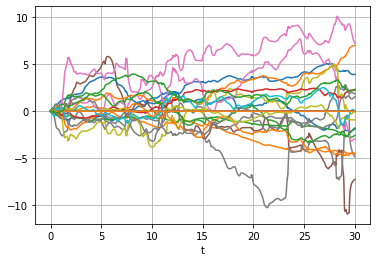

In [25]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.ylim(0,10)
plt.show()

In [26]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [27]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [28]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [29]:
psi = var_ansatz(start_point,psi_0)

In [30]:
expt_value_u = np.zeros(len(time_domain))
expt_value_v = np.zeros(len(time_domain))

psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    for i in range(L+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

    expt_value_u[tt] = np.real(np.conj(psi_var)@observable_matrix@psi_var)/norm**2
    expt_value_v[tt] = np.real(np.conj(hamiltonian_evolution(time_domain[tt])@psi)@observable_matrix@hamiltonian_evolution(time_domain[tt])@psi)



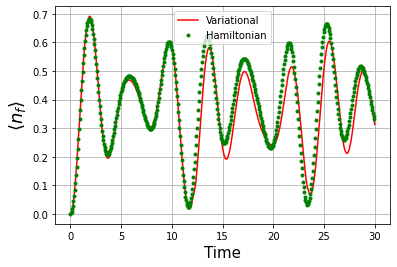

In [33]:
plt.plot(time_domain,expt_value_u, color = "red",label = "Variational")
plt.plot(time_domain[::20],expt_value_v[::20],".",color = "green",label = "Hamiltonian")

plt.ylabel(r"$\langle n_f\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

In [ ]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
